
# Adversarial Example Generation

**Author:** [Nathan Inkawhich](https://github.com/inkawhich), modifications by Julien Girard

This tutorial aims at raising your awareness to the security vulnerabilities
of ML models, and will give insights into the topic of adversarial
examples on machine learning. Adversarial examples are carefully constructed examples
that cause misclassification by a neural network, while being visually imperceptible by a human observer from the base sample.

We will be working on the MNIST dataset, introduced earlier, and we will use the simple
Fast Gradient Sign Method to generate adversarial examples.

But first, we will define some notions and present a brief overview of the litterature on adversarial examples.



## Adversarial perturbation

Let us define a classifier $\mathcal{f}$, a base input $\mathbf{x}$, and the ground-truth output of our (correct) classification $\mathcal{f}(\mathbf{x}) = \mathbf{y}$.
An _adversarial perturbation_ $\delta$ is a synthetized perturbation such that $\left\lVert \delta \right\rVert_p \leq \varepsilon$ and $\mathcal{f}(\mathbf{x}+\delta) \neq \mathbf{y}$. 

Here $\left\lVert \cdot \right\rVert_p$ is a norm metric, typically $L_2$ or $L_1$ over the pixel intensities.

There has been a prolific work on this topic since the seminal work of Goodfellow et al., [Intriguing properties of neural networks](https://arxiv.org/abs/1312.6199) where the authors exhibited the first adversarial examples.
Several adversarial generation methods were developped on multiple settings: most of them make use of gradient informations. See for instance [Fast Gradient Sign Method](https://arxiv.org/abs/1412.6572),  [Carlini and Wagner Attack](https://arxiv.org/abs/1608.04644) and [DeepFool](https://arxiv.org/abs/1511.04599). 
 
 Adversarial perturbations can be replicated between architectures and datasets, making attacks by transfer possible: one can learn a model, synthetize adversarial examples on it and use them on the target model: see [this work](https://arxiv.org/abs/1605.07277) on that topic.
 
 Adversarial examples can be used in other settings that image classification, such as in [audio-to-text synthesis](https://arxiv.org/abs/1810.11793) or [in the physical world](https://arxiv.org/abs/1804.05810) (adversarial perturbations are generated, printed and put in a physical environment, where they successfully a detection algorithm).

There are very few effective defenses, most of the proposed defenses failed to hold on subsequent attacks (see [here](https://arxiv.org/abs/1802.05666), [here](https://arxiv.org/abs/1608.04644) or [here](https://arxiv.org/abs/1902.02322)). A potential defense is _adversarial training_: generating adversarial examples during training and re-labelling them so that the classifier does not misclassify them: see [this work](https://arxiv.org/abs/1706.06083) for instance. Its efficiency has been shown to be specific to the metric considered: adversarial training on a particular metric is not efficient on adversarial perturbations generated following another metric.


There are several theories on adversarial examples, but there is not clear consensus yet. One can read the following papers that try to explain their existence: [Adversarial Spheres](https://arxiv.org/abs/1801.02774) and [Robustness may be at odds with accuracy](https://arxiv.org/abs/1805.12152v3).

## Threat Model


For context, there are many categories of adversarial attacks, each with
a different goal and assumption of the attacker’s knowledge. However, in
general the overarching goal is to add the least amount of perturbation
to the input data to cause the desired misclassification. There are
several kinds of assumptions about the attacker’s knowledge, two of which
are: **white-box** and **black-box**.
  * A *white-box* attack assumes the
  attacker has full knowledge and access to the model, including
  architecture, inputs, outputs, and weights.
  * A *black-box* attack assumes
  the attacker only has access to the inputs and outputs of the model, and
  knows nothing about the underlying architecture or weights.

There are
also several types of goals, including **misclassification** and
**source/target misclassification**.
  * A goal of *misclassification* means
  the adversary only wants the output classification to be wrong but does
  not care what the new classification is. 
  * A *source/target
  misclassification* means the adversary wants to alter an image that is
  originally of a specific source class so that it is classified as a
  specific target class.

In our case, the FGSM attack we will study is a *white-box* attack with the goal of
*misclassification*. With this background information, we can now
discuss the attack in detail.

### Fast Gradient Sign Attack


One of the first and most popular adversarial attacks to date is
referred to as the *Fast Gradient Sign Attack (FGSM)* and is described
by Goodfellow et. al. in [Explaining and Harnessing Adversarial
Examples](https://arxiv.org/abs/1412.6572). The attack is fast to implement and deploy.
It is designed to attack neural networks by
leveraging the way they learn, *gradients*.
The idea is simple: instead of using the backpropagated gradient
to minimize the loss by adjusting the weights, the attack *adjusts the input data to maximize
the loss* based on the same backpropagated gradients. In other words,
the attack uses the gradient of the loss w.r.t the input data, then
adjusts the input data to maximize the loss.

Note that this attack aims at _misclassifying_ an input, without considering the actual classification. More elaborated attacks allow us to choose the target label. 

### Notations

Let $\mathbf{x}$ be the original input image
correctly classified as a label $\mathbf{y}$  (the ground truth label
for $\mathbf{x}$). $\mathbf{\theta}$ represents the model
parameters, and $J(\mathbf{\theta}, \mathbf{x}, \mathbf{y})$ is the loss
that is used to train the network. 
Note that the chain rule makes it easy to compute the derivative of the loss w.r.t. the input as a function of the derivative of the loss w.r.t. the weights of the first layer of the network (same chain rule except for the last multiplication).
The attack backpropagates the
gradient back to the input data to calculate
$\nabla_{x} J(\mathbf{\theta}, \mathbf{x}, y)$. Then, it adjusts
the input data by a small step $\varepsilon$ in the direction that will
maximize the loss: 
$\mathrm{sign}(\nabla_{x} J(\mathbf{\theta}, \mathbf{x}, y))$. The resulting perturbed image, $x'$, is then
*misclassified* by the target network as another label $\mathbf{y_p}$.

**Boring code**

Various libraries imports

In [0]:
#@title
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

## Implementation





### Parameters section

*  **epsilons**: List of epsilon values to use for the run. Note that 0 should be in the list because it represents the model
   performance on the original test set (a perturbation with amplitude 0 is applied).
  The larger the epsilon, the more noticeable the perturbations
   but the more effective the attack in terms of degrading model
   accuracy. Since we do work on PIL and MNIST images here, 
   the range of possible values is $[0,1]$.

* **pretrained_model**: Path to the model to attack. You can use your model trained on the previous tutorial by simply calling it if you are still on the  same colab environment, or you can upload the file containing the neural network you downloaded previously. 

In [0]:
epsilons = list(np.arange(0.,0.35,0.05))
pretrained_model = "./mnist_model.pth"

**Boring code**

This code redefines the architecture used in the previous environment. Copy-paste your architecture if it is different.




In [0]:
# LeNet Model definition
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x



**Boring code**

This snippet reinitializes the MNIST dataset and loads the neural network (trained weights, knowing the architecture defined above).

In [0]:
# MNIST Test dataset and dataloader declaration
test_set = datasets.MNIST('./data/MNIST', train=False, download=True, transform=transforms.Compose([
            transforms.ToTensor()]))
test_loader = torch.utils.data.DataLoader(test_set, 
        batch_size=1, shuffle=True)

# Initialize the network
net = Net()

# Load the pretrained model
net.load_state_dict(torch.load(pretrained_model, map_location='cpu'))

# Set the model in evaluation mode. In this case this is for the Dropout layers
net.eval()

Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

## FGSM Attack

Now, we can define the function that creates the adversarial examples by
perturbing the original inputs. 

Define a `fgsm_attack` function taking three inputs:
  * `image`: the original sample ($\mathbf{x}$). It's a `Torch.tensor` of 
  size (`batch_size`,`1`,`28`,`28`)
  * `epsilon`: the pixel-wise perturbation we want to apply: $\varepsilon$. Simply a `float`.
  * `data_grad`: the gradient of the loss computed by the forward pass of the original sample:
  $\nabla_{x} J(\mathbf{\theta}, \mathbf{x}, \mathbf{y})$.
  It's a `Torch.tensor` of size (`batch_size`,`1`,`28`,`28`)

The function
must calculate a perturbed image $\mathbf{x'}$ such that
\begin{align} \mathbf{x'} = \mathbf{x} + \varepsilon\, \mathrm{sign}(\nabla_{x} J(\mathbf{\theta}, \mathbf{x}, \mathbf{y}))\end{align}

Finally, in order to maintain the original range of the data, the
returned perturbed image must be clipped to range $[0,1]$.

### Your code

In [0]:
# replace this with your implementation
def fgsm_attack(image, epsilon, data_grad):
  print('Performing FGSM attack')  

###  Possible solution

In [0]:
#@title
# FGSM attack code
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

## Testing Function


First, test your attack on a random image of the dataset:



Text(0.5, 1.0, 'Pertubated prediction 8')

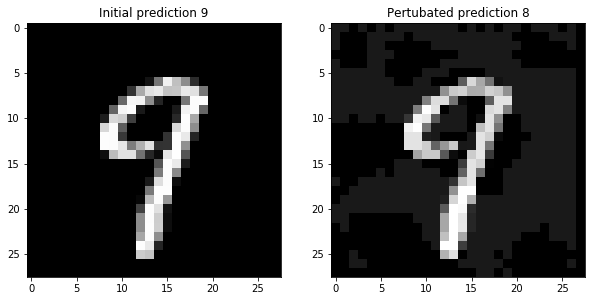

In [0]:
def get_random_mnist_img(set):
  idx=np.random.randint(0,10000)
  data,target=set.__getitem__(idx)
  return data,target

def imshow(t):
  a=t.numpy()
  plt.imshow(a,cmap='gray')
  
  
epsilon=0.1

clean, ground_truth = get_random_mnist_img(test_set)
clean = clean.unsqueeze(0)
ground_truth = torch.tensor(ground_truth).unsqueeze(0)
clean.requires_grad=True
clean_output = net(clean)
loss = F.nll_loss(clean_output, ground_truth)
net.zero_grad()
loss.backward()
data_grad = clean.grad.data
####
#### attack snipped
#### 
pert = fgsm_attack(image=clean,epsilon=epsilon,data_grad=data_grad)
####
#### attack snipped
#### 
pert_output = net(pert)
init_pred = clean_output.max(1, keepdim=True)[1]
final_pred = pert_output.max(1, keepdim=True)[1]

fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(10, 5))
ax[0].imshow(clean.detach().view(28,28),cmap='gray')
ax[0].set_title('Initial prediction {}'.format(init_pred.item()))
ax[1].imshow(pert.detach().view(28,28),cmap='gray')
ax[1].set_title('Pertubated prediction {}'.format(final_pred.item()))

Modify the previous testing routine to generate adversarial samples during testing and compute success rates.
Write a `test` function taking the following parameters:
  * **model**: the architecture to attack
  * **test_loader**: the dataset loader utility to sample from
  * **eps**: value of epsilon to use in FGSM attack

### Possible solution

In [0]:
#@title
def test( model, test_loader, epsilon ):
    # We will be working on the CPU provided by google virtual machine here
    device = 'cpu'
    
    # Accuracy counter
    correct = 0
    adv_examples = []

    # Loop over all examples in test set
    for batch_idx,(data, target) in enumerate(test_loader):

        # Send the data and label to the device
        data, target = data.to(device), target.to(device)

        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        # If the initial prediction is wrong, dont bother attacking, just move on
        if init_pred.item() != target.item():
            continue

        # Calculate the loss
        loss = F.nll_loss(output, target)

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect datagrad
        data_grad = data.grad.data

        # Call FGSM Attack
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        # Re-classify the perturbed image
        output = model(perturbed_data)
        # Check for success
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        if final_pred.item() == target.item():
            correct += 1
            # Special case for saving 0 epsilon examples
            if (epsilon == 0) and (len(adv_examples) < 5):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            # Save some adv examples for visualization later
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {:.2f}%".format(epsilon, correct, len(test_loader), final_acc*100))

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples

## Run Attack

You can launch the attack on the whole dataset for different values of epsilon $\varepsilon$. 



**Boring code**

Perform the test using the test function you wrote, and store accuracies and some adversarial samples.

In [0]:
accuracies = []
examples = []

# Run test for each epsilon
for eps in epsilons:
    acc, ex = test(net, test_loader, eps)
    accuracies.append(acc)
    examples.append(ex)

Epsilon: 0.0	Test Accuracy = 9669 / 10000 = 96.69%
Epsilon: 0.05	Test Accuracy = 9127 / 10000 = 91.27%
Epsilon: 0.1	Test Accuracy = 7800 / 10000 = 78.00%
Epsilon: 0.15000000000000002	Test Accuracy = 4948 / 10000 = 49.48%
Epsilon: 0.2	Test Accuracy = 2484 / 10000 = 24.84%
Epsilon: 0.25	Test Accuracy = 932 / 10000 = 9.32%
Epsilon: 0.30000000000000004	Test Accuracy = 318 / 10000 = 3.18%


## Results


## Accuracy vs Epsilon


The first result is the _accuracy versus $\varepsilon$_ plot. A higher $\varepsilon$ means a higher perturbation towards the direction that maximises the loss. Random-level accuracy is reached between $\varepsilon=0.2$ and $\varepsilon=0.3$. 





**Boring code**



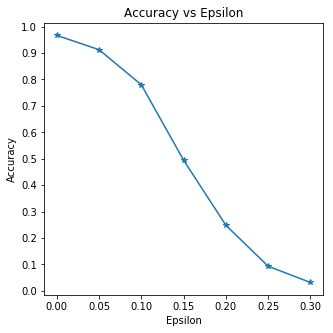

In [0]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

## Sample Adversarial Examples

The choice of value for $\varepsilon$ yields a tradeoff between accuracy
degredation and perceptability of the attack by human eye.

Here, we
show some examples of successful adversarial examples at each $\varepsilon$
value. Each row of the plot shows a different $\varepsilon$ value. The first
row is the $\varepsilon=0$ examples, which represent the original
“clean” images with no perturbation. The title of each image shows the
“original classification -> adversarial classification.” Notice, the
perturbations start to become evident at $\varepsilon=0.15$ and are
quite evident at $\varepsilon=0.3$. However, in all cases humans are
still capable of identifying the correct class despite the added noise.




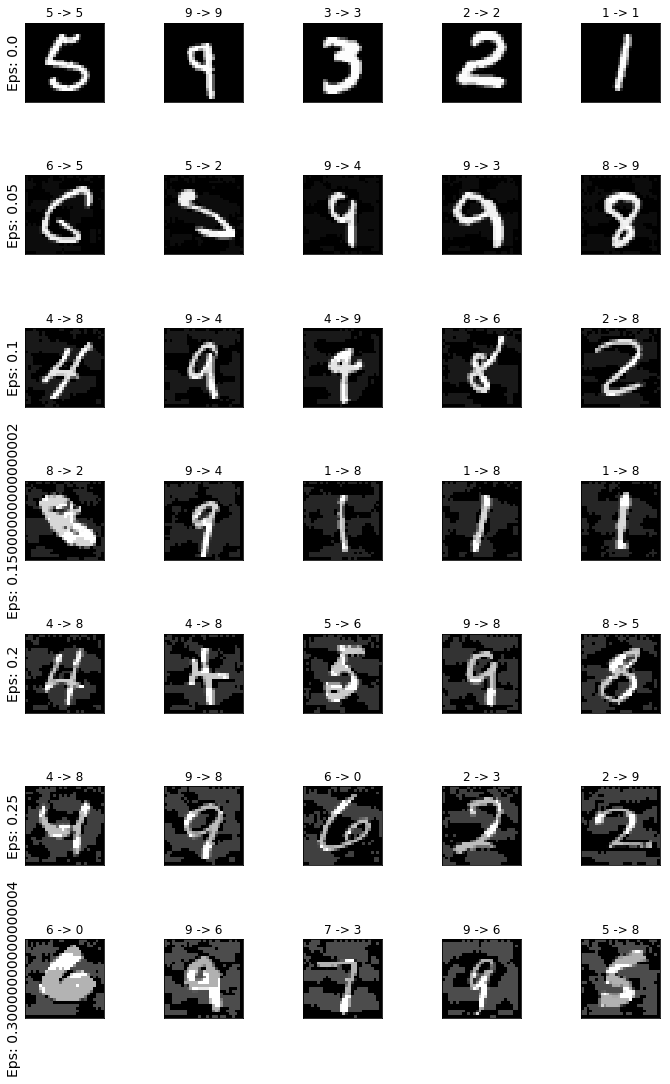

In [0]:
# Plot several examples of adversarial samples at each epsilon
cnt = 0
plt.figure(figsize=(10,15))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title("{} -> {}".format(orig, adv))
        plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()

## Opening

As said in the introduction, there are more complex and efficient adversarial attacks. [AdverTorch](https://github.com/BorealisAI/advertorch) is an example of an initiative to gather multiple adversarial attack implementations under the same API for rapid experiment. 

There is for now no systematic way to detect adversarial samples, and to distinguish adversarial noise from classical noise, making it more difficult to devise sound defenses. However, robustness against adversarial examples can be seen as some kind of specification for neural networks to check. Indeed, the problem of adversarial robustness is relatively easy to formulate. For a few years, some work has been undergoing to try to check robustness properties using formal methods. See for instance this most excellent [survey](http://mpawankumar.info/tutorials/vmcai2019/index.html) on the topic of formal method for adversarial robustness. One can for instance look at the work of Martin Vechev and Guy Katz, whom will both be giving invited talks during the spring school.


Note also that there are other vulnerabilities inherent to machine learning programs. One can for instance look at [memberships attacks](https://www.cs.cornell.edu/~shmat/shmat_oak17.pdf) or [model stealing](https://arxiv.org/abs/1609.02943), which can be seen as privacy flaws.
